In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm
import h5py
sys.path.append('/home/jma819/post_cmfe_analysis')
#sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
from matplotlib import pyplot as plt
from matplotlib import animation, rc
import dlc_utils
import av
from IPython.display import HTML

In [3]:
from importlib import reload
reload(dlc_utils)

<module 'dlc_utils' from '/home/jma819/post_cmfe_analysis/dlc_utils.py'>

In [4]:
#dlc_directory = '/volumes/My_Passport/dlc_analysis/behavcamvideos/open_field_miniscope/'
dlc_directory = '/projects/b1118/behaviorvideos/'
experiment_folders = [folder for folder in os.listdir(dlc_directory) if '_H' in folder]

In [33]:
for folder in tqdm(experiment_folders[2:]):
    output_directory = dlc_directory+folder+'/'
    session_name = folder
    print(folder)
    dlc_output_files = os.listdir(output_directory)
    dlc_output_files.sort()    
    names = []
    dlc_dfs = []
    for output_file in dlc_output_files:
        if output_file.endswith('000.h5'):
            print(output_file)
            dlc_output = pd.read_hdf(output_directory + output_file)
            
            ## before calculating centroid remove regions where 
            # find regions where likelihood is less than maybe .9-1
            for body_part in list(set(dlc_output.columns.get_level_values(1))):
                low_likelihood_indicies = dlc_output.loc[dlc_output['DLC_resnet50_Open_Field_v2Jan27shuffle1_150000'][body_part]['likelihood']<0.9].index
                #remove coordinate values from low likelihood regions 
                dlc_output.loc[low_likelihood_indicies, ('DLC_resnet50_Open_Field_v2Jan27shuffle1_150000', body_part, 'x')]=np.nan
                dlc_output.loc[low_likelihood_indicies, ('DLC_resnet50_Open_Field_v2Jan27shuffle1_150000', body_part, 'y')]=np.nan
          
            dlc_output = dlc_utils.calculate_centroid(dlc_output)
            dlc_output.head()
            coordinates_delta_df = dlc_utils.difference_df(dlc_output)
            df_columns = list(dlc_output.columns)

            print('calculating velocity')
            velocity_df = pd.DataFrame(np.transpose(np.array([np.array([dlc_utils.velocity(coordinates_delta_df[body_part]['x'].values[frame],coordinates_delta_df[body_part]['y'].values[frame]) for frame in range(len(coordinates_delta_df))]) for body_part in list(set([df_columns[item][1] for item in range(len(df_columns))]))])), 
                                       columns=list(set([df_columns[item][1] for item in range(len(df_columns))]))) 
            for body_part in list(set([df_columns[item][1] for item in range(len(df_columns))])):
                velocity_df[body_part+'_likelihood']=dlc_output[df_columns[0][0]][body_part]['likelihood'].values
            
            names.append(output_file)
            dlc_dfs.append(velocity_df)

    session_compiled = pd.concat(dlc_dfs, keys=names)

    #save compiled session 
    session_compiled.to_hdf(output_directory+session_name+'_compiled_session_02152021.h5', key='df')
    session_compiled.to_csv(output_directory+session_name+'_compiled_session_02152021.csv')

    #create behavior data aligned to the msCam frames
    #need to have switch here for msCam and BehavCam cam #s
    #in these recordings behavcam records at faster framerate (30fps vs 20fps) so will have more frames
    timsestamps_file = output_directory+'timestamp.dat'
    frame_clock_df = pd.read_table(timsestamps_file)
    Cam0_timestamps = frame_clock_df[frame_clock_df['camNum'] == 0]  
    Cam1_timestamps = frame_clock_df[frame_clock_df['camNum'] == 1]
    if len(Cam1_timestamps)>len(Cam0_timestamps):
        msCam_camnum=0
        behavCam_camnum=1
    elif len(Cam1_timestamps)<len(Cam0_timestamps):
        msCam_camnum=1
        behavCam_camnum=0
    else:
        print('check timestamp file')
        break   

    # changing selection of frames from session compiled dataframe to account for 1 indexing of frames in timestamp file -- should be fixed 
    aligned = dlc_utils.downsample_dlc_to_behavior(output_directory+session_name+'_compiled_session_02152021.h5', output_directory+'timestamp.dat', 
                                                   msCam_camnum, behavCam_camnum)

    aligned_td = aligned.set_index(pd.to_timedelta(np.linspace(0, aligned['sys_clock_behavCam'].values[-1]/1000, len(aligned)), unit='s'), drop=False)
    
    #smooth data by downsampling and interpolating 
    velocities_for_smoothing = aligned_td[list(set(dlc_output.columns.get_level_values(1)))]
    dont_smooth = aligned_td[[label for label in list(set(aligned_td.columns)) if label not in list(set(dlc_output.columns.get_level_values(1)))]]
    
    interpolated = dlc_utils.downsample_and_interpolate(velocities_for_smoothing, '.05S', '1S', 'linear')
    

    interpolated_for_output = pd.concat([interpolated.reset_index(drop=True)[0:len(dont_smooth)], dont_smooth.reset_index(drop=True)], axis=1).set_index(pd.to_timedelta(np.linspace(0, dont_smooth['sys_clock_behavCam'].values[-1]/1000, len(aligned)), unit='s'), drop=False)


    aligned_td.to_csv(output_directory+session_name+'_dlc_tracking_foranalysis_unsmoothed_02152021.csv')
    interpolated_for_output.to_csv(output_directory+session_name+'_dlc_tracking_foranalysis_02152021.csv')
    output_directory+session_name+'_dlc_tracking_foranalysis.csv'


  0%|          | 0/26 [00:00<?, ?it/s]

GRIN018_H17_M41_S43
behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam03DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam04DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam05DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam06DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam07DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam08DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam09DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam



  0%|          | 0/22389 [00:00<?, ?it/s]

  0%|          | 72/22389 [00:00<00:31, 717.92it/s]

  1%|          | 136/22389 [00:00<00:32, 690.42it/s]

  1%|          | 207/22389 [00:00<00:31, 695.85it/s]

  1%|          | 278/22389 [00:00<00:31, 697.45it/s]

  2%|▏         | 347/22389 [00:00<00:31, 693.53it/s]

  2%|▏         | 416/22389 [00:00<00:31, 690.85it/s]

  2%|▏         | 484/22389 [00:00<00:31, 686.52it/s]

  2%|▏         | 547/22389 [00:00<00:33, 660.66it/s]

  3%|▎         | 617/22389 [00:00<00:32, 670.00it/s]

  3%|▎         | 685/22389 [00:01<00:32, 672.13it/s]

  3%|▎         | 753/22389 [00:01<00:32, 671.47it/s]

  4%|▎         | 821/22389 [00:01<00:32, 671.72it/s]

  4%|▍         | 889/22389 [00:01<00:32, 671.48it/s]

  4%|▍         | 956/22389 [00:01<00:32, 667.21it/s]

  5%|▍         | 1023/22389 [00:01<00:32, 663.50it/s]

  5%|▍         | 1090/22389 [00:01<00:32, 661.94it/s]

  5%|▌         | 1156/22389 [00:01<00:32, 658.36it/s]

  5%|▌         | 1222/22389 [00:01<

GRIN035_H13_M50_S58
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam13DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam14DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam15DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam16DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam17DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam18DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam19DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam1DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam20DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam2



  0%|          | 0/29579 [00:00<?, ?it/s]

  0%|          | 49/29579 [00:00<01:00, 484.65it/s]

  0%|          | 93/29579 [00:00<01:02, 468.30it/s]

  0%|          | 140/29579 [00:00<01:03, 463.36it/s]

  1%|          | 184/29579 [00:00<01:04, 454.16it/s]

  1%|          | 235/29579 [00:00<01:02, 467.31it/s]

  1%|          | 280/29579 [00:00<01:03, 460.82it/s]

  1%|          | 324/29579 [00:00<01:04, 452.28it/s]

  1%|▏         | 376/29579 [00:00<01:02, 468.62it/s]

  1%|▏         | 428/29579 [00:00<01:00, 482.79it/s]

  2%|▏         | 475/29579 [00:01<01:02, 462.18it/s]

  2%|▏         | 521/29579 [00:01<01:05, 440.37it/s]

  2%|▏         | 565/29579 [00:01<01:06, 434.26it/s]

  2%|▏         | 609/29579 [00:01<01:07, 428.46it/s]

  2%|▏         | 652/29579 [00:01<01:09, 414.94it/s]

  2%|▏         | 694/29579 [00:01<01:09, 415.59it/s]

  2%|▏         | 736/29579 [00:01<01:09, 415.85it/s]

  3%|▎         | 778/29579 [00:01<01:11, 402.16it/s]

  3%|▎         | 819/29579 [00:01<01:11

GRIN038_H15_M39_S40
behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam03DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam04DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam05DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam06DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam07DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam08DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam09DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam



  0%|          | 0/38957 [00:00<?, ?it/s]

  0%|          | 47/38957 [00:00<01:23, 463.67it/s]

  0%|          | 96/38957 [00:00<01:22, 469.73it/s]

  0%|          | 145/38957 [00:00<01:21, 474.41it/s]

  0%|          | 193/38957 [00:00<01:21, 475.97it/s]

  1%|          | 241/38957 [00:00<01:21, 477.10it/s]

  1%|          | 289/38957 [00:00<01:20, 477.76it/s]

  1%|          | 338/38957 [00:00<01:20, 478.97it/s]

  1%|          | 387/38957 [00:00<01:20, 480.63it/s]

  1%|          | 435/38957 [00:00<01:20, 480.36it/s]

  1%|          | 484/38957 [00:01<01:19, 481.86it/s]

  1%|▏         | 531/38957 [00:01<01:24, 457.29it/s]

  1%|▏         | 577/38957 [00:01<01:30, 423.88it/s]

  2%|▏         | 620/38957 [00:01<01:32, 413.40it/s]

  2%|▏         | 662/38957 [00:01<01:33, 409.86it/s]

  2%|▏         | 704/38957 [00:01<01:38, 388.33it/s]

  2%|▏         | 744/38957 [00:01<01:37, 390.33it/s]

  2%|▏         | 784/38957 [00:01<01:41, 376.86it/s]

  2%|▏         | 822/38957 [00:01<01:44

GRIN034_H16_M13_S22
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam13DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam14DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam15DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam16DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam17DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam18DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam19DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam1DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam20DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam2



  0%|          | 0/26320 [00:00<?, ?it/s]

  0%|          | 43/26320 [00:00<01:02, 422.24it/s]

  0%|          | 79/26320 [00:00<01:05, 400.29it/s]

  0%|          | 117/26320 [00:00<01:06, 392.08it/s]

  1%|          | 157/26320 [00:00<01:06, 392.50it/s]

  1%|          | 197/26320 [00:00<01:06, 391.75it/s]

  1%|          | 231/26320 [00:00<01:10, 369.99it/s]

  1%|          | 269/26320 [00:00<01:09, 372.77it/s]

  1%|          | 313/26320 [00:00<01:06, 389.52it/s]

  1%|▏         | 356/26320 [00:00<01:04, 399.88it/s]

  2%|▏         | 395/26320 [00:01<01:07, 385.07it/s]

  2%|▏         | 433/26320 [00:01<01:08, 377.97it/s]

  2%|▏         | 475/26320 [00:01<01:06, 388.90it/s]

  2%|▏         | 517/26320 [00:01<01:05, 396.15it/s]

  2%|▏         | 557/26320 [00:01<01:07, 383.33it/s]

  2%|▏         | 603/26320 [00:01<01:03, 402.89it/s]

  2%|▏         | 648/26320 [00:01<01:02, 413.33it/s]

  3%|▎         | 690/26320 [00:01<01:03, 404.66it/s]

  3%|▎         | 734/26320 [00:01<01:01

GRIN027_H13_M29_S44
behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam03DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam04DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam05DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam06DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam07DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam08DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam09DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam



  0%|          | 0/30403 [00:00<?, ?it/s]

  0%|          | 38/30403 [00:00<01:20, 378.85it/s]

  0%|          | 71/30403 [00:00<01:23, 361.30it/s]

  0%|          | 109/30403 [00:00<01:23, 364.76it/s]

  0%|          | 145/30403 [00:00<01:23, 362.70it/s]

  1%|          | 182/30403 [00:00<01:23, 362.19it/s]

  1%|          | 226/30403 [00:00<01:18, 382.43it/s]

  1%|          | 264/30403 [00:00<01:19, 381.10it/s]

  1%|          | 313/30403 [00:00<01:13, 407.18it/s]

  1%|          | 353/30403 [00:00<01:17, 385.97it/s]

  1%|▏         | 395/30403 [00:01<01:16, 391.85it/s]

  1%|▏         | 438/30403 [00:01<01:14, 401.37it/s]

  2%|▏         | 480/30403 [00:01<01:14, 403.42it/s]

  2%|▏         | 521/30403 [00:01<01:17, 384.84it/s]

  2%|▏         | 560/30403 [00:01<01:20, 372.84it/s]

  2%|▏         | 598/30403 [00:01<01:22, 361.30it/s]

  2%|▏         | 635/30403 [00:01<01:22, 359.61it/s]

  2%|▏         | 674/30403 [00:01<01:21, 364.09it/s]

  2%|▏         | 711/30403 [00:01<01:24

GRIN038_H13_M37_S23
behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam03DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam04DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam05DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam06DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam07DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam08DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam09DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam



  0%|          | 0/39021 [00:00<?, ?it/s]

  0%|          | 35/39021 [00:00<01:52, 347.85it/s]

  0%|          | 74/39021 [00:00<01:48, 359.39it/s]

  0%|          | 113/39021 [00:00<01:46, 365.09it/s]

  0%|          | 153/39021 [00:00<01:43, 373.91it/s]

  0%|          | 183/39021 [00:00<01:52, 345.19it/s]

  1%|          | 215/39021 [00:00<01:55, 335.83it/s]

  1%|          | 247/39021 [00:00<01:57, 330.01it/s]

  1%|          | 283/39021 [00:00<01:54, 337.08it/s]

  1%|          | 318/39021 [00:00<01:55, 336.28it/s]

  1%|          | 358/39021 [00:01<01:50, 350.79it/s]

  1%|          | 393/39021 [00:01<01:57, 327.82it/s]

  1%|          | 426/39021 [00:01<01:57, 328.37it/s]

  1%|          | 466/39021 [00:01<01:51, 346.02it/s]

  1%|▏         | 501/39021 [00:01<01:57, 328.16it/s]

  1%|▏         | 535/39021 [00:01<01:57, 326.54it/s]

  1%|▏         | 568/39021 [00:01<02:01, 317.23it/s]

  2%|▏         | 607/39021 [00:01<01:55, 333.90it/s]

  2%|▏         | 642/39021 [00:01<01:53

GRIN039_H12_M26_S54
behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam03DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam04DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam05DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam06DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam13DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam14DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam15DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam



  0%|          | 0/38775 [00:00<?, ?it/s]

  0%|          | 38/38775 [00:00<01:44, 371.25it/s]

  0%|          | 79/38775 [00:00<01:42, 379.24it/s]

  0%|          | 114/38775 [00:00<01:44, 369.86it/s]

  0%|          | 145/38775 [00:00<01:50, 349.17it/s]

  0%|          | 179/38775 [00:00<01:51, 345.11it/s]

  1%|          | 208/38775 [00:00<02:00, 319.68it/s]

  1%|          | 237/38775 [00:00<02:09, 298.63it/s]

  1%|          | 266/38775 [00:00<02:11, 293.14it/s]

  1%|          | 303/38775 [00:00<02:03, 311.41it/s]

  1%|          | 334/38775 [00:01<02:04, 308.32it/s]

  1%|          | 368/38775 [00:01<02:01, 316.73it/s]

  1%|          | 405/38775 [00:01<01:56, 330.29it/s]

  1%|          | 442/38775 [00:01<01:52, 339.72it/s]

  1%|          | 476/38775 [00:01<01:56, 327.39it/s]

  1%|▏         | 515/38775 [00:01<01:51, 342.16it/s]

  1%|▏         | 550/38775 [00:01<01:54, 332.96it/s]

  2%|▏         | 588/38775 [00:01<01:50, 345.08it/s]

  2%|▏         | 623/38775 [00:01<01:55

GRIN035_H13_M31_S20
behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam03DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam04DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam05DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam06DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam07DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam08DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam09DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam



  0%|          | 0/40997 [00:00<?, ?it/s]

  0%|          | 40/40997 [00:00<01:43, 397.14it/s]

  0%|          | 85/40997 [00:00<01:39, 411.64it/s]

  0%|          | 124/40997 [00:00<01:41, 402.26it/s]

  0%|          | 165/40997 [00:00<01:41, 402.20it/s]

  0%|          | 196/40997 [00:00<01:51, 366.37it/s]

  1%|          | 229/40997 [00:00<01:55, 353.81it/s]

  1%|          | 262/40997 [00:00<01:59, 341.68it/s]

  1%|          | 307/40997 [00:00<01:50, 366.68it/s]

  1%|          | 350/40997 [00:00<01:46, 382.17it/s]

  1%|          | 395/40997 [00:01<01:41, 399.61it/s]

  1%|          | 444/40997 [00:01<01:36, 421.11it/s]

  1%|          | 487/40997 [00:01<01:42, 396.56it/s]

  1%|▏         | 527/40997 [00:01<01:45, 383.86it/s]

  1%|▏         | 566/40997 [00:01<01:48, 373.65it/s]

  1%|▏         | 604/40997 [00:01<01:53, 355.47it/s]

  2%|▏         | 640/40997 [00:01<01:58, 339.16it/s]

  2%|▏         | 675/40997 [00:01<01:58, 340.76it/s]

  2%|▏         | 716/40997 [00:01<01:52

GRIN013_H13_M33_S54
behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam03DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam04DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam05DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam06DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam07DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam08DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam09DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam



  0%|          | 0/35701 [00:00<?, ?it/s]

  0%|          | 42/35701 [00:00<01:25, 416.22it/s]

  0%|          | 76/35701 [00:00<01:31, 389.83it/s]

  0%|          | 121/35701 [00:00<01:27, 404.96it/s]

  0%|          | 161/35701 [00:00<01:28, 401.23it/s]

  1%|          | 209/35701 [00:00<01:24, 420.65it/s]

  1%|          | 245/35701 [00:00<01:29, 397.67it/s]

  1%|          | 294/35701 [00:00<01:24, 419.53it/s]

  1%|          | 334/35701 [00:00<01:26, 410.81it/s]

  1%|          | 378/35701 [00:00<01:24, 419.01it/s]

  1%|          | 422/35701 [00:01<01:23, 424.41it/s]

  1%|▏         | 464/35701 [00:01<01:27, 400.95it/s]

  1%|▏         | 504/35701 [00:01<01:28, 395.93it/s]

  2%|▏         | 544/35701 [00:01<01:29, 393.79it/s]

  2%|▏         | 584/35701 [00:01<01:28, 395.19it/s]

  2%|▏         | 624/35701 [00:01<01:32, 378.52it/s]

  2%|▏         | 662/35701 [00:01<01:33, 373.58it/s]

  2%|▏         | 700/35701 [00:01<01:36, 361.17it/s]

  2%|▏         | 737/35701 [00:01<01:38

GRIN018_H16_M13_S53
behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam03DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam04DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam05DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam06DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam07DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam08DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam09DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam



  0%|          | 0/40052 [00:00<?, ?it/s]

  0%|          | 41/40052 [00:00<01:37, 409.96it/s]

  0%|          | 87/40052 [00:00<01:34, 422.70it/s]

  0%|          | 140/40052 [00:00<01:29, 448.42it/s]

  0%|          | 178/40052 [00:00<01:33, 424.74it/s]

  1%|          | 221/40052 [00:00<01:34, 421.53it/s]

  1%|          | 259/40052 [00:00<01:38, 404.62it/s]

  1%|          | 311/40052 [00:00<01:31, 433.08it/s]

  1%|          | 360/40052 [00:00<01:28, 447.63it/s]

  1%|          | 411/40052 [00:00<01:25, 464.52it/s]

  1%|          | 457/40052 [00:01<01:27, 450.14it/s]

  1%|▏         | 502/40052 [00:01<01:29, 443.57it/s]

  1%|▏         | 549/40052 [00:01<01:28, 448.78it/s]

  1%|▏         | 594/40052 [00:01<01:30, 437.42it/s]

  2%|▏         | 638/40052 [00:01<01:30, 435.59it/s]

  2%|▏         | 682/40052 [00:01<01:34, 418.68it/s]

  2%|▏         | 733/40052 [00:01<01:28, 442.21it/s]

  2%|▏         | 778/40052 [00:01<01:28, 443.44it/s]

  2%|▏         | 834/40052 [00:01<01:23

GRIN034_H15_M28_S2
behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam03DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam04DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam05DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam06DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam07DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam08DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam09DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam1



  0%|          | 0/52765 [00:00<?, ?it/s]

  0%|          | 36/52765 [00:00<02:29, 353.28it/s]

  0%|          | 70/52765 [00:00<02:31, 348.34it/s]

  0%|          | 104/52765 [00:00<02:32, 345.36it/s]

  0%|          | 140/52765 [00:00<02:31, 347.35it/s]

  0%|          | 179/52765 [00:00<02:26, 358.20it/s]

  0%|          | 219/52765 [00:00<02:22, 368.86it/s]

  0%|          | 252/52765 [00:00<02:31, 347.51it/s]

  1%|          | 285/52765 [00:00<02:39, 329.69it/s]

  1%|          | 328/52765 [00:00<02:29, 351.59it/s]

  1%|          | 363/52765 [00:01<02:31, 346.67it/s]

  1%|          | 398/52765 [00:01<02:39, 327.93it/s]

  1%|          | 435/52765 [00:01<02:34, 339.12it/s]

  1%|          | 469/52765 [00:01<02:34, 337.93it/s]

  1%|          | 503/52765 [00:01<02:46, 314.59it/s]

  1%|          | 544/52765 [00:01<02:34, 337.22it/s]

  1%|          | 579/52765 [00:01<02:36, 333.76it/s]

  1%|          | 613/52765 [00:01<02:45, 315.95it/s]

  1%|          | 646/52765 [00:01<02:50

GRIN035_H14_M40_S34
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam13DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam14DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam15DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam16DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam17DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam18DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam19DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam1DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam20DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam2



  0%|          | 0/26771 [00:00<?, ?it/s]

  0%|          | 35/26771 [00:00<01:17, 344.90it/s]

  0%|          | 72/26771 [00:00<01:16, 349.82it/s]

  0%|          | 108/26771 [00:00<01:15, 352.61it/s]

  1%|          | 146/26771 [00:00<01:14, 359.65it/s]

  1%|          | 180/26771 [00:00<01:15, 351.55it/s]

  1%|          | 222/26771 [00:00<01:11, 369.16it/s]

  1%|          | 256/26771 [00:00<01:16, 347.94it/s]

  1%|          | 295/26771 [00:00<01:13, 359.46it/s]

  1%|▏         | 338/26771 [00:00<01:09, 378.01it/s]

  1%|▏         | 375/26771 [00:01<01:12, 362.51it/s]

  2%|▏         | 418/26771 [00:01<01:09, 377.03it/s]

  2%|▏         | 456/26771 [00:01<01:10, 372.68it/s]

  2%|▏         | 498/26771 [00:01<01:08, 384.53it/s]

  2%|▏         | 540/26771 [00:01<01:06, 392.83it/s]

  2%|▏         | 580/26771 [00:01<01:15, 348.85it/s]

  2%|▏         | 619/26771 [00:01<01:12, 358.40it/s]

  2%|▏         | 656/26771 [00:01<01:14, 350.28it/s]

  3%|▎         | 692/26771 [00:01<01:15

GRIN039_H14_M8_S53
behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam03DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam04DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam05DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam06DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam07DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam08DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam09DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam1



  0%|          | 0/32697 [00:00<?, ?it/s]

  0%|          | 35/32697 [00:00<01:35, 342.48it/s]

  0%|          | 65/32697 [00:00<01:39, 326.81it/s]

  0%|          | 99/32697 [00:00<01:39, 329.24it/s]

  0%|          | 139/32697 [00:00<01:34, 346.30it/s]

  1%|          | 174/32697 [00:00<01:33, 347.14it/s]

  1%|          | 211/32697 [00:00<01:32, 351.96it/s]

  1%|          | 249/32697 [00:00<01:32, 351.01it/s]

  1%|          | 282/32697 [00:00<01:34, 343.67it/s]

  1%|          | 319/32697 [00:00<01:32, 350.53it/s]

  1%|          | 353/32697 [00:01<01:36, 335.64it/s]

  1%|          | 387/32697 [00:01<01:36, 335.81it/s]

  1%|▏         | 423/32697 [00:01<01:34, 340.95it/s]

  1%|▏         | 457/32697 [00:01<01:37, 330.93it/s]

  1%|▏         | 490/32697 [00:01<01:40, 320.09it/s]

  2%|▏         | 522/32697 [00:01<01:45, 305.02it/s]

  2%|▏         | 556/32697 [00:01<01:42, 313.96it/s]

  2%|▏         | 588/32697 [00:01<01:54, 280.56it/s]

  2%|▏         | 621/32697 [00:01<01:49,

GRIN012_H16_M57_S23
behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam03DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam04DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam05DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam06DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam07DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam08DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam09DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam



  0%|          | 0/71651 [00:00<?, ?it/s]

  0%|          | 28/71651 [00:00<04:32, 262.78it/s]

  0%|          | 54/71651 [00:00<04:34, 261.20it/s]

  0%|          | 80/71651 [00:00<04:34, 260.80it/s]

  0%|          | 106/71651 [00:00<04:34, 260.38it/s]

  0%|          | 134/71651 [00:00<04:32, 262.32it/s]

  0%|          | 165/71651 [00:00<04:20, 274.73it/s]

  0%|          | 196/71651 [00:00<04:11, 283.56it/s]

  0%|          | 229/71651 [00:00<04:01, 295.64it/s]

  0%|          | 260/71651 [00:00<03:58, 298.92it/s]

  0%|          | 290/71651 [00:01<04:03, 293.60it/s]

  0%|          | 325/71651 [00:01<03:51, 307.66it/s]

  0%|          | 356/71651 [00:01<04:03, 292.45it/s]

  1%|          | 387/71651 [00:01<04:01, 295.15it/s]

  1%|          | 420/71651 [00:01<03:55, 302.89it/s]

  1%|          | 451/71651 [00:01<04:09, 284.96it/s]

  1%|          | 480/71651 [00:01<04:26, 267.06it/s]

  1%|          | 509/71651 [00:01<04:22, 271.41it/s]

  1%|          | 537/71651 [00:01<04:29,

GRIN039_H12_M33_S29
behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam03DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam04DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam05DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam06DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam13DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam14DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam15DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam



  0%|          | 0/43137 [00:00<?, ?it/s]

  0%|          | 31/43137 [00:00<02:21, 304.11it/s]

  0%|          | 71/43137 [00:00<02:12, 325.69it/s]

  0%|          | 103/43137 [00:00<02:14, 318.92it/s]

  0%|          | 142/43137 [00:00<02:07, 336.09it/s]

  0%|          | 181/43137 [00:00<02:03, 348.47it/s]

  1%|          | 217/43137 [00:00<02:02, 349.32it/s]

  1%|          | 257/43137 [00:00<01:58, 360.99it/s]

  1%|          | 293/43137 [00:00<01:58, 360.15it/s]

  1%|          | 328/43137 [00:00<02:08, 332.40it/s]

  1%|          | 364/43137 [00:01<02:06, 338.33it/s]

  1%|          | 398/43137 [00:01<02:09, 329.32it/s]

  1%|          | 437/43137 [00:01<02:04, 343.58it/s]

  1%|          | 472/43137 [00:01<02:04, 342.41it/s]

  1%|          | 507/43137 [00:01<02:05, 339.37it/s]

  1%|▏         | 541/43137 [00:01<02:12, 321.26it/s]

  1%|▏         | 575/43137 [00:01<02:10, 325.74it/s]

  1%|▏         | 608/43137 [00:01<02:12, 321.02it/s]

  1%|▏         | 641/43137 [00:01<02:11

GRIN012_H17_M32_S17
behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam03DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam04DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam05DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam06DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam07DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam08DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam09DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam



  0%|          | 0/20836 [00:00<?, ?it/s]

  0%|          | 60/20836 [00:00<00:34, 599.00it/s]

  1%|          | 131/20836 [00:00<00:33, 626.18it/s]

  1%|          | 185/20836 [00:00<00:34, 597.53it/s]

  1%|          | 253/20836 [00:00<00:33, 618.35it/s]

  1%|▏         | 305/20836 [00:00<00:35, 571.86it/s]

  2%|▏         | 365/20836 [00:00<00:35, 578.27it/s]

  2%|▏         | 424/20836 [00:00<00:36, 559.53it/s]

  2%|▏         | 490/20836 [00:00<00:34, 584.51it/s]

  3%|▎         | 546/20836 [00:00<00:36, 560.87it/s]

  3%|▎         | 606/20836 [00:01<00:35, 570.83it/s]

  3%|▎         | 662/20836 [00:01<00:35, 564.33it/s]

  3%|▎         | 718/20836 [00:01<00:39, 512.59it/s]

  4%|▎         | 781/20836 [00:01<00:36, 542.59it/s]

  4%|▍         | 849/20836 [00:01<00:34, 575.40it/s]

  4%|▍         | 917/20836 [00:01<00:33, 601.18it/s]

  5%|▍         | 985/20836 [00:01<00:31, 621.10it/s]

  5%|▌         | 1053/20836 [00:01<00:31, 636.59it/s]

  5%|▌         | 1120/20836 [00:01<00

GRIN026_H16_M35_S34
behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam03DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam04DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam05DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam06DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam07DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam08DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam09DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam



  0%|          | 0/25930 [00:00<?, ?it/s]

  0%|          | 47/25930 [00:00<00:55, 465.72it/s]

  0%|          | 90/25930 [00:00<00:57, 452.96it/s]

  1%|          | 136/25930 [00:00<00:56, 453.64it/s]

  1%|          | 181/25930 [00:00<00:56, 452.26it/s]

  1%|          | 218/25930 [00:00<01:00, 422.56it/s]

  1%|          | 267/25930 [00:00<00:58, 439.66it/s]

  1%|          | 312/25930 [00:00<00:57, 442.68it/s]

  1%|▏         | 359/25930 [00:00<00:56, 449.61it/s]

  2%|▏         | 402/25930 [00:00<00:58, 438.14it/s]

  2%|▏         | 449/25930 [00:01<00:57, 445.96it/s]

  2%|▏         | 498/25930 [00:01<00:55, 456.93it/s]

  2%|▏         | 543/25930 [00:01<00:57, 437.97it/s]

  2%|▏         | 587/25930 [00:01<00:59, 425.34it/s]

  2%|▏         | 630/25930 [00:01<01:00, 418.99it/s]

  3%|▎         | 682/25930 [00:01<00:56, 443.01it/s]

  3%|▎         | 727/25930 [00:01<00:57, 435.21it/s]

  3%|▎         | 771/25930 [00:01<01:00, 417.51it/s]

  3%|▎         | 827/25930 [00:01<00:55

GRIN034_H19_M0_S18
behavCam10DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam11DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam12DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam13DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam14DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam15DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam16DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam17DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5
calculating velocity
behavCam18DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5


KeyboardInterrupt: 

In [ ]:
#velocities_for_smoothing

In [63]:
## load results to plot examples of movement events from behavCam videos
session_compiled = pd.read_csv('/projects/b1118/behaviorvideos/GRIN012_H17_M46_S35/GRIN012_H17_M46_S35_compiled_session_02152021.csv')
aligned_unsmoothed = pd.read_csv('/projects/b1118/behaviorvideos/GRIN012_H17_M46_S35/GRIN012_H17_M46_S35_dlc_tracking_foranalysis_unsmoothed_02152021.csv')
interpolated = pd.read_csv('/projects/b1118/behaviorvideos/GRIN012_H17_M46_S35/GRIN012_H17_M46_S35_dlc_tracking_foranalysis_02152021.csv')

In [20]:
plt.plot(aligned_unsmoothed['tail_base'][0:1000])

NameError: name 'aligned_unsmoothed' is not defined

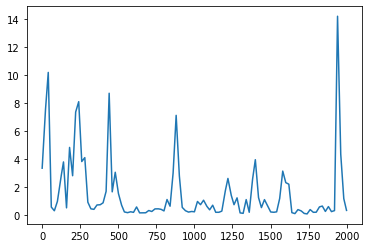

In [70]:
plt.plot(interpolated['tail_base'][0:2000])

In [8]:
session_compiled.head()

,Unnamed: 0,Unnamed: 1,tail_base,ear_right,centroid,miniscope_light,ear_left,tail_base_likelihood,ear_right_likelihood,centroid_likelihood,miniscope_light_likelihood,ear_left_likelihood
0,behavCam01DLC_resnet50_Open_Field_v2Jan27shuff...,0,NaN,NaN,NaN,NaN,NaN,1.0,0.543999,0.601432,0.000948,0.860782
1,behavCam01DLC_resnet50_Open_Field_v2Jan27shuff...,1,0.020989,NaN,NaN,NaN,NaN,1.0,0.544328,0.597836,0.000909,0.846108
2,behavCam01DLC_resnet50_Open_Field_v2Jan27shuff...,2,0.223639,NaN,NaN,NaN,NaN,1.0,0.568832,0.615546,0.001060,0.892291
3,behavCam01DLC_resnet50_Open_Field_v2Jan27shuff...,3,0.125337,NaN,NaN,NaN,NaN,1.0,0.466004,0.574586,0.000912,0.831427
4,behavCam01DLC_resnet50_Open_Field_v2Jan27shuff...,4,0.208928,NaN,NaN,NaN,NaN,1.0,0.496595,0.589579,0.000906,0.860816


In [9]:
session_compiled.loc[session_compiled['Unnamed: 0']=='behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5']

,Unnamed: 0,Unnamed: 1,tail_base,ear_right,centroid,miniscope_light,ear_left,tail_base_likelihood,ear_right_likelihood,centroid_likelihood,miniscope_light_likelihood,ear_left_likelihood
0,behavCam01DLC_resnet50_Open_Field_v2Jan27shuff...,0,NaN,NaN,NaN,NaN,NaN,1.0,0.543999,0.601432,0.000948,0.860782
1,behavCam01DLC_resnet50_Open_Field_v2Jan27shuff...,1,0.020989,NaN,NaN,NaN,NaN,1.0,0.544328,0.597836,0.000909,0.846108
2,behavCam01DLC_resnet50_Open_Field_v2Jan27shuff...,2,0.223639,NaN,NaN,NaN,NaN,1.0,0.568832,0.615546,0.001060,0.892291
3,behavCam01DLC_resnet50_Open_Field_v2Jan27shuff...,3,0.125337,NaN,NaN,NaN,NaN,1.0,0.466004,0.574586,0.000912,0.831427
4,behavCam01DLC_resnet50_Open_Field_v2Jan27shuff...,4,0.208928,NaN,NaN,NaN,NaN,1.0,0.496595,0.589579,0.000906,0.860816
...,...,...,...,...,...,...,...,...,...,...,...,...
995,behavCam01DLC_resnet50_Open_Field_v2Jan27shuff...,995,0.195469,NaN,NaN,NaN,NaN,1.0,0.174045,0.321404,0.004252,0.107322
996,behavCam01DLC_resnet50_Open_Field_v2Jan27shuff...,996,0.362859,NaN,NaN,NaN,NaN,1.0,0.170958,0.317127,0.003837,0.093713
997,behavCam01DLC_resnet50_Open_Field_v2Jan27shuff...,997,0.201971,NaN,NaN,NaN,NaN,1.0,0.157686,0.306189,0.003926,0.063142
998,behavCam01DLC_resnet50_Open_Field_v2Jan27shuff...,998,0.198633,NaN,NaN,NaN,NaN,1.0,0.104328,0.289012,0.004548,0.047174


(0, 60)

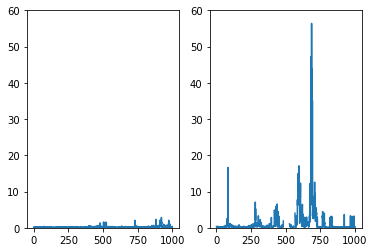

In [10]:
frames_within_movie = np.linspace(0, 1000, 1000)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(frames_within_movie, session_compiled.loc[session_compiled['Unnamed: 0']=='behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5']['tail_base'])
ax1.set_ylim(0, 60)
ax2.plot(frames_within_movie, session_compiled.loc[session_compiled['Unnamed: 0']=='behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5']['tail_base'])
ax2.set_ylim(0, 60)

In [11]:
# frames (within video) to look at 
frame_region = (500, 750)
# loads needed behavior cam video and stores frames in dictionary 
video = av.open('/projects/b1118/behaviorvideos/GRIN013_H13_M33_S54/behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000_labeled.mp4')
total_frames = video.streams.video[0].frames
movie_images = {}
for i, frame in enumerate(video.decode(video=0)):
    img = frame.to_image()  # PIL image
    movie_images[i] = img
    if i%100==0:
        print("Frame: %d/%d ..." % (i, total_frames))
video.close()
movie_shape = np.shape(movie_images[1])
frame_subset = [movie_images[i] for i in range(frame_region[0], frame_region[1])]

Frame: 0/1000 ...
Frame: 100/1000 ...
Frame: 200/1000 ...
Frame: 300/1000 ...
Frame: 400/1000 ...
Frame: 500/1000 ...
Frame: 600/1000 ...
Frame: 700/1000 ...
Frame: 800/1000 ...
Frame: 900/1000 ...


In [12]:
#matplotlib_images = [plt.imshow(frame_subset[i]) for i in range(len(frame_subset))]

In [13]:
len(frame_subset)

250

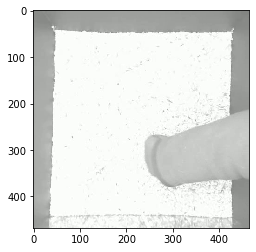

In [14]:
plt.imshow(frame_subset[0])

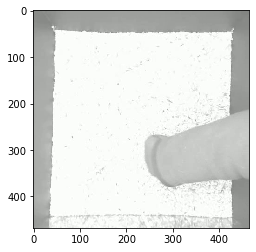

In [15]:
fig = plt.figure()
im = plt.imshow(frame_subset[0])
#ani = animation.ArtistAnimation(fig, matplotlib_images, interval=50, blit=True, repeat_delay=1000)
#HTML(ani.to_html5_video())
def init():
    im.set_data(frame_subset[0])
def animate(i):
    im.set_data(frame_subset[i])
    return im

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(frame_subset), interval=50)

In [16]:
HTML(ani.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available